In [1]:
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys
import pickle 
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import corner

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import sys, platform, os
from numpy import sqrt, sin, cos, pi
import scipy.constants as cst

camb_path = os.path.realpath(os.path.join(os.getcwd(),'..'))
sys.path.insert(0,camb_path)
import camb
from camb import model, initialpower
tf.__version__

'2.8.0'

In [2]:
import scipy.integrate as integrate
import scipy.special as special     
from scipy.interpolate import CubicSpline
from scipy import interpolate
from scipy.optimize import curve_fit
from scipy.integrate import quad, dblquad

In [3]:
train_params = np.load('LHS_params_1dim100_NL.npz')                #LHS  

In [4]:
print(train_params.files)                                       # Each of the keys has an 'np.array' of values

['h']


In [5]:
#print(train_params['omega_b'])

n_samples = len(train_params['h'])
print('number of training samples:', len(train_params['h'])) 
print(train_params['h'])

number of training samples: 100
[0.74343434 0.72565657 0.67717172 0.71919192 0.76606061 0.64484848
 0.79030303 0.77252525 0.71272727 0.64646465 0.77737374 0.78545455
 0.68525253 0.79353535 0.68040404 0.65777778 0.76444444 0.76282828
 0.64808081 0.66262626 0.73212121 0.73050505 0.71757576 0.74181818
 0.69171717 0.72888889 0.66585859 0.78060606 0.77414141 0.71434343
 0.69656566 0.75474747 0.66909091 0.64969697 0.67393939 0.79191919
 0.68686869 0.66424242 0.67878788 0.6820202  0.70141414 0.73373737
 0.68848485 0.7369697  0.7240404  0.7579798  0.76767677 0.70949495
 0.69979798 0.70464646 0.7789899  0.68363636 0.67232323 0.76121212
 0.8        0.64323232 0.70626263 0.77575758 0.69333333 0.73858586
 0.6610101  0.76929293 0.69494949 0.75151515 0.65616162 0.77090909
 0.74505051 0.7159596  0.7030303  0.64161616 0.65939394 0.79515152
 0.78707071 0.69818182 0.74989899 0.70787879 0.72080808 0.75313131
 0.64       0.66747475 0.65292929 0.74828283 0.78868687 0.74020202
 0.72727273 0.75636364 0.67555

In [6]:
cosmo_params = np.zeros((len(train_params['h']), 1))
print(cosmo_params[4])

cosmo_params[:, 0] = train_params['h']

## Training input params:
h = cosmo_params[:, 0]

[0.]


In [7]:
with open('pk_data_1dim100_NL1.pkl', 'rb') as f, open('pk_data_1dim100_NL2.pkl', 'rb') as g:
    pk_matrix = pickle.load(f)
    pk_nonlin_matrix = pickle.load(g)

pk_matrix = np.asarray(pk_matrix).astype('float32')
pk_matrix.dtype

In [8]:
h.dtype

dtype('float64')

In [10]:
# Training input params and output param:

train_H0 = 100*h                          
train_pk = pk_matrix                    
train_pk_nonlin = pk_nonlin_matrix 
print("train_pk shape:", np.shape(train_pk))
print("train_pk_nonlin shape:", np.shape(train_pk_nonlin))
print(len(train_pk[4]))

train_pk shape: (100, 500)
train_pk_nonlin shape: (100, 500)
500


In [11]:
input_params = np.vstack([train_H0])                                        # 1x5000

input_params_transpose = np.transpose(input_params)
print(np.shape(input_params_transpose))
print(np.shape(train_pk))

input_data = pd.DataFrame(input_params_transpose)
input_data.columns = ['H0']

output_data = pd.DataFrame(train_pk)
output_data_nonlin = pd.DataFrame(train_pk_nonlin)  
print(input_data)                                                         #5000x1
print(output_data)

(100, 1)
(100, 500)
           H0
0   74.343434
1   72.565657
2   67.717172
3   71.919192
4   76.606061
..        ...
95  78.222222
96  71.111111
97  73.535354
98  75.959596
99  74.666667

[100 rows x 1 columns]
           0           1           2           3           4           5    \
0   545.449252  558.179355  571.206182  584.536621  598.177716  612.136669   
1   511.930119  523.878274  536.104942  548.616579  561.419797  574.521370   
2   427.854946  437.841522  448.060950  458.518641  469.220124  480.171059   
3   500.102863  511.775047  523.719317  535.941997  548.449555  561.248602   
4   590.250730  604.025953  618.122216  632.546966  647.307825  662.412590   
..         ...         ...         ...         ...         ...         ...   
95  623.702803  638.258324  653.153052  668.394853  683.991778  699.952058   
96  485.587371  496.920937  508.518715  520.386834  532.531565  544.959328   
97  530.030362  542.400748  555.059490  568.013281  581.268965  594.833544   
98  577.

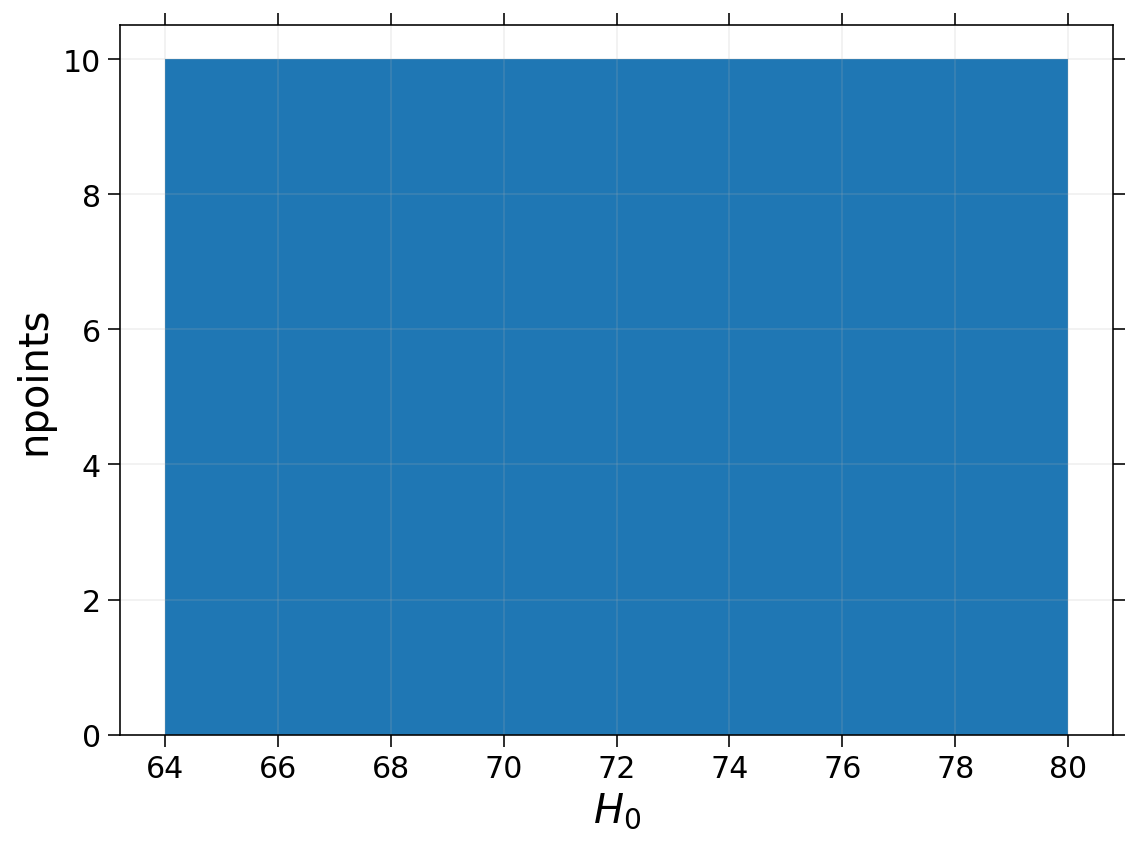

In [13]:
plt.figure(figsize = (8,6))
plt.hist(input_data['H0'])
plt.xlabel(r'$H_{0}$')
plt.ylabel('npoints')
plt.rc('axes', labelsize=16)
plt.rc('axes', labelsize=20, titlesize=20)
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15
plt.grid(alpha=0.2)
plt.grid(alpha=0.2)
plt.tick_params(top=True,right=True, length=6)
plt.tight_layout()

In [16]:
# Standardising:

train_input_data = StandardScaler()
test_output_data = StandardScaler()

# Storing the fit object for later reference
scaled_input = train_input_data.fit(input_data.values)              # Compute the mean and std to be used for later scaling

scaled_output = test_output_data.fit(output_data.values)
scaled_output_nonlin = test_output_data.fit(output_data_nonlin.values)

# Generating the standardized values of input and output:
X = scaled_input.transform(input_data.values)                              # Perform standardisation by centring and scaling    
y = scaled_output.transform(output_data.values)     
y_nonlin = scaled_output_nonlin.transform(output_data_nonlin.values)
#print(X)

-1.7148160424389376 21.94463242632387


(array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10.]),
 array([-1.71481604, -1.37185283, -1.02888963, -0.68592642, -0.34296321,
         0.        ,  0.34296321,  0.68592642,  1.02888963,  1.37185283,
         1.71481604]),
 <BarContainer object of 10 artists>)

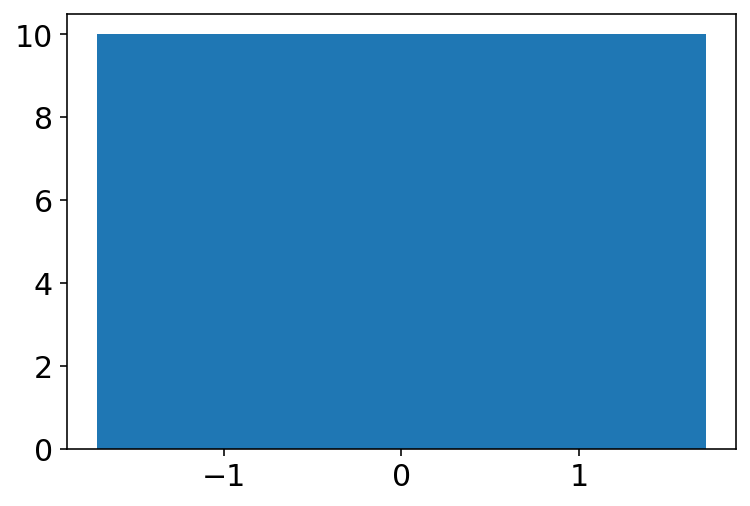

In [17]:
print(X.min(), y.max())
plt.hist(X)

In [18]:
# Split the data into training and testing sets:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(np.shape(X_train))    # 4000x1
print(X_train.shape[1])     # 1


X_train_nonlin, X_test_nonlin, y_train_nonlin, y_test_nonlin = train_test_split(X, y_nonlin, test_size=0.2, random_state=42)
print(np.shape(X_train_nonlin))
print(X_train.shape[1])    

(80, 1)
1
(80, 1)
1


In [20]:
#print(X_train)

In [22]:
print("y_test samples, pts:", np.shape(y_test))
print("y_train samples, pts:", np.shape(y_train))
print("X_train samples, pts:", np.shape(X_train))
print("X_test samples, pts:",np.shape(X_test))

print("y_test_nonlin samples, pts:", np.shape(y_test_nonlin))
print("y_train_nonlin samples, pts:", np.shape(y_train_nonlin))
print("X_train_nonlin samples, pts:", np.shape(X_train_nonlin))
print("X_test_nonlin samples, pts:",np.shape(X_test_nonlin))
#print("X_train:", X_train)
#print("X_test:", X_test)

y_test samples, pts: (20, 500)
y_train samples, pts: (80, 500)
X_train samples, pts: (80, 1)
X_test samples, pts: (20, 1)
y_test_nonlin samples, pts: (20, 500)
y_train_nonlin samples, pts: (80, 500)
X_train_nonlin samples, pts: (80, 1)
X_test_nonlin samples, pts: (20, 1)


In [30]:
%%time
#Building the NN:

# reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.01,
#                                   patience=30, min_lr=0.000000001)
# e_s = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=100)

tf_model = Sequential()
# Defining the input layer of the model
tf_model.add(Dense(units=250, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu')) # 
 
# Defining 1st Hidden layer of the model
tf_model.add(Dense(units=250, kernel_initializer='normal', activation='relu'))

# Defining 2nd Hidden layer of the model
tf_model.add(Dense(units=250, kernel_initializer='normal', activation='relu'))

# Defining the 3rd hidden layer of the model
#tf_model.add(Dense(units=150, kernel_initializer='normal', activation='relu'))  

# Defining the 4th hidden layer of the model
#tf_model.add(Dense(units=150, kernel_initializer='normal', activation='relu')) 

#Defining the output layer of the model
tf_model.add(Dense(500, kernel_initializer='normal'))
 
# opt = keras.optimizers.Adam(learning_rate=1e-4)
opt = keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)  
    
# Compiling the model
tf_model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])
 
# Fitting the ANN to the Training set
hist_ = tf_model.fit(X_train, y_train, batch_size = 2, epochs = 500, validation_split=0.2, verbose=1) # callbacks=[reduce_lr, e_s],
            
# Mean absolute percentage error
MAPE = np.mean(np.abs((y_test - tf_model.predict(X_test))/y_test))*100
print(np.shape(100-MAPE))
print('Accuracy:', 100-MAPE)
#99.44523163935358, l_rate = 1e-4, 250 epochs, batch size = 50, 0.9837
#99.59918915882399, l_rate = 1e-4, 250 epochs, batch size = 20, 0.9934
tf_model.summary()

Epoch 1/500
32/32 [==============================] - 1s 7ms/step - loss: 549.4594 - accuracy: 0.1250 - val_loss: 545.4020 - val_accuracy: 0.5000
Epoch 2/500
32/32 [==============================] - 0s 4ms/step - loss: 548.4888 - accuracy: 0.0625 - val_loss: 543.6177 - val_accuracy: 0.0625
Epoch 3/500
32/32 [==============================] - 0s 4ms/step - loss: 544.8873 - accuracy: 0.1250 - val_loss: 536.9422 - val_accuracy: 0.0625
Epoch 4/500
32/32 [==============================] - 0s 4ms/step - loss: 531.8198 - accuracy: 0.1250 - val_loss: 515.1943 - val_accuracy: 0.0625
Epoch 5/500
32/32 [==============================] - 0s 5ms/step - loss: 496.3720 - accuracy: 0.1250 - val_loss: 461.3989 - val_accuracy: 0.0625
Epoch 6/500
32/32 [==============================] - 0s 4ms/step - loss: 418.8077 - accuracy: 0.1250 - val_loss: 358.9722 - val_accuracy: 0.0625
Epoch 7/500
32/32 [==============================] - 0s 4ms/step - loss: 293.1089 - accuracy: 0.2812 - val_loss: 215.8917 - val_ac

32/32 [==============================] - 0s 3ms/step - loss: 2.3734 - accuracy: 0.4531 - val_loss: 2.4606 - val_accuracy: 0.3125
Epoch 59/500
32/32 [==============================] - 0s 3ms/step - loss: 2.3572 - accuracy: 0.4531 - val_loss: 2.4397 - val_accuracy: 0.3125
Epoch 60/500
32/32 [==============================] - 0s 3ms/step - loss: 2.3214 - accuracy: 0.4531 - val_loss: 2.4262 - val_accuracy: 0.3125
Epoch 61/500
32/32 [==============================] - 0s 4ms/step - loss: 2.3067 - accuracy: 0.4531 - val_loss: 2.4220 - val_accuracy: 0.3125
Epoch 62/500
32/32 [==============================] - 0s 3ms/step - loss: 2.2556 - accuracy: 0.4531 - val_loss: 2.3415 - val_accuracy: 0.3125
Epoch 63/500
32/32 [==============================] - 0s 4ms/step - loss: 2.2272 - accuracy: 0.4531 - val_loss: 2.3560 - val_accuracy: 0.3125
Epoch 64/500
32/32 [==============================] - 0s 3ms/step - loss: 2.2273 - accuracy: 0.4531 - val_loss: 2.3237 - val_accuracy: 0.3125
Epoch 65/500
32/32 

Epoch 116/500
32/32 [==============================] - 0s 3ms/step - loss: 0.7071 - accuracy: 0.4531 - val_loss: 0.7315 - val_accuracy: 0.3125
Epoch 117/500
32/32 [==============================] - 0s 3ms/step - loss: 0.6890 - accuracy: 0.4531 - val_loss: 0.7091 - val_accuracy: 0.3125
Epoch 118/500
32/32 [==============================] - 0s 4ms/step - loss: 0.6612 - accuracy: 0.4531 - val_loss: 0.6896 - val_accuracy: 0.3125
Epoch 119/500
32/32 [==============================] - 0s 3ms/step - loss: 0.6419 - accuracy: 0.4531 - val_loss: 0.6676 - val_accuracy: 0.3125
Epoch 120/500
32/32 [==============================] - 0s 3ms/step - loss: 0.6224 - accuracy: 0.4531 - val_loss: 0.6373 - val_accuracy: 0.3125
Epoch 121/500
32/32 [==============================] - 0s 3ms/step - loss: 0.6002 - accuracy: 0.4531 - val_loss: 0.6067 - val_accuracy: 0.3125
Epoch 122/500
32/32 [==============================] - 0s 3ms/step - loss: 0.5810 - accuracy: 0.4531 - val_loss: 0.5970 - val_accuracy: 0.3125

32/32 [==============================] - 0s 3ms/step - loss: 0.1642 - accuracy: 0.7969 - val_loss: 0.1456 - val_accuracy: 0.8750
Epoch 174/500
32/32 [==============================] - 0s 3ms/step - loss: 0.1614 - accuracy: 0.8125 - val_loss: 0.1445 - val_accuracy: 0.8750
Epoch 175/500
32/32 [==============================] - 0s 3ms/step - loss: 0.1583 - accuracy: 0.7969 - val_loss: 0.1416 - val_accuracy: 0.8750
Epoch 176/500
32/32 [==============================] - 0s 4ms/step - loss: 0.1597 - accuracy: 0.7969 - val_loss: 0.1421 - val_accuracy: 0.8750
Epoch 177/500
32/32 [==============================] - 0s 4ms/step - loss: 0.1586 - accuracy: 0.8125 - val_loss: 0.1373 - val_accuracy: 0.8750
Epoch 178/500
32/32 [==============================] - 0s 3ms/step - loss: 0.1564 - accuracy: 0.8125 - val_loss: 0.1379 - val_accuracy: 0.8750
Epoch 179/500
32/32 [==============================] - 0s 4ms/step - loss: 0.1551 - accuracy: 0.7969 - val_loss: 0.1366 - val_accuracy: 0.8750
Epoch 180/500

32/32 [==============================] - 0s 4ms/step - loss: 0.0918 - accuracy: 0.7969 - val_loss: 0.0855 - val_accuracy: 0.8750
Epoch 231/500
32/32 [==============================] - 0s 4ms/step - loss: 0.0890 - accuracy: 0.8125 - val_loss: 0.0788 - val_accuracy: 0.8750
Epoch 232/500
32/32 [==============================] - 0s 4ms/step - loss: 0.0878 - accuracy: 0.8125 - val_loss: 0.0794 - val_accuracy: 0.8750
Epoch 233/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0869 - accuracy: 0.8125 - val_loss: 0.0784 - val_accuracy: 0.8750
Epoch 234/500
32/32 [==============================] - 0s 4ms/step - loss: 0.0864 - accuracy: 0.8125 - val_loss: 0.0817 - val_accuracy: 0.8750
Epoch 235/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0865 - accuracy: 0.7969 - val_loss: 0.0768 - val_accuracy: 0.8750
Epoch 236/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0828 - accuracy: 0.8125 - val_loss: 0.0764 - val_accuracy: 0.8750
Epoch 237/500

32/32 [==============================] - 0s 4ms/step - loss: 0.0359 - accuracy: 0.9062 - val_loss: 0.0385 - val_accuracy: 0.8750
Epoch 288/500
32/32 [==============================] - 0s 4ms/step - loss: 0.0368 - accuracy: 0.8906 - val_loss: 0.0388 - val_accuracy: 0.8750
Epoch 289/500
32/32 [==============================] - 0s 4ms/step - loss: 0.0358 - accuracy: 0.8750 - val_loss: 0.0384 - val_accuracy: 0.8750
Epoch 290/500
32/32 [==============================] - 0s 4ms/step - loss: 0.0356 - accuracy: 0.8750 - val_loss: 0.0358 - val_accuracy: 0.9375
Epoch 291/500
32/32 [==============================] - 0s 4ms/step - loss: 0.0342 - accuracy: 0.8906 - val_loss: 0.0380 - val_accuracy: 0.9375
Epoch 292/500
32/32 [==============================] - 0s 4ms/step - loss: 0.0343 - accuracy: 0.8906 - val_loss: 0.0367 - val_accuracy: 0.8750
Epoch 293/500
32/32 [==============================] - 0s 4ms/step - loss: 0.0332 - accuracy: 0.8750 - val_loss: 0.0397 - val_accuracy: 0.9375
Epoch 294/500

32/32 [==============================] - 0s 4ms/step - loss: 0.0177 - accuracy: 0.9375 - val_loss: 0.0197 - val_accuracy: 0.9375
Epoch 345/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0182 - accuracy: 0.9531 - val_loss: 0.0207 - val_accuracy: 0.8750
Epoch 346/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0220 - accuracy: 0.9375 - val_loss: 0.0331 - val_accuracy: 1.0000
Epoch 347/500
32/32 [==============================] - 0s 5ms/step - loss: 0.0257 - accuracy: 0.9375 - val_loss: 0.0299 - val_accuracy: 0.8750
Epoch 348/500
32/32 [==============================] - 0s 4ms/step - loss: 0.0271 - accuracy: 0.9531 - val_loss: 0.0195 - val_accuracy: 0.9375
Epoch 349/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0221 - accuracy: 0.9688 - val_loss: 0.0227 - val_accuracy: 0.9375
Epoch 350/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0189 - accuracy: 0.9688 - val_loss: 0.0210 - val_accuracy: 0.9375
Epoch 351/500

32/32 [==============================] - 0s 4ms/step - loss: 0.0115 - accuracy: 0.9844 - val_loss: 0.0143 - val_accuracy: 0.8750
Epoch 402/500
32/32 [==============================] - 0s 4ms/step - loss: 0.0121 - accuracy: 0.9531 - val_loss: 0.0110 - val_accuracy: 0.9375
Epoch 403/500
32/32 [==============================] - 0s 4ms/step - loss: 0.0133 - accuracy: 0.9531 - val_loss: 0.0156 - val_accuracy: 0.9375
Epoch 404/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0123 - accuracy: 0.9531 - val_loss: 0.0145 - val_accuracy: 0.8750
Epoch 405/500
32/32 [==============================] - 0s 4ms/step - loss: 0.0125 - accuracy: 0.9375 - val_loss: 0.0144 - val_accuracy: 0.8750
Epoch 406/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0126 - accuracy: 0.9531 - val_loss: 0.0121 - val_accuracy: 0.8750
Epoch 407/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0119 - accuracy: 0.9375 - val_loss: 0.0108 - val_accuracy: 0.9375
Epoch 408/500

32/32 [==============================] - 0s 6ms/step - loss: 0.0090 - accuracy: 0.9688 - val_loss: 0.0122 - val_accuracy: 0.8750
Epoch 459/500
32/32 [==============================] - 0s 4ms/step - loss: 0.0108 - accuracy: 0.9688 - val_loss: 0.0137 - val_accuracy: 0.8750
Epoch 460/500
32/32 [==============================] - 0s 4ms/step - loss: 0.0114 - accuracy: 0.9531 - val_loss: 0.0082 - val_accuracy: 0.8750
Epoch 461/500
32/32 [==============================] - 0s 4ms/step - loss: 0.0105 - accuracy: 0.9531 - val_loss: 0.0084 - val_accuracy: 0.8750
Epoch 462/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0099 - accuracy: 0.9688 - val_loss: 0.0120 - val_accuracy: 0.8750
Epoch 463/500
32/32 [==============================] - 0s 4ms/step - loss: 0.0081 - accuracy: 0.9688 - val_loss: 0.0078 - val_accuracy: 0.8750
Epoch 464/500
32/32 [==============================] - 0s 5ms/step - loss: 0.0080 - accuracy: 0.9531 - val_loss: 0.0082 - val_accuracy: 0.8750
Epoch 465/500

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

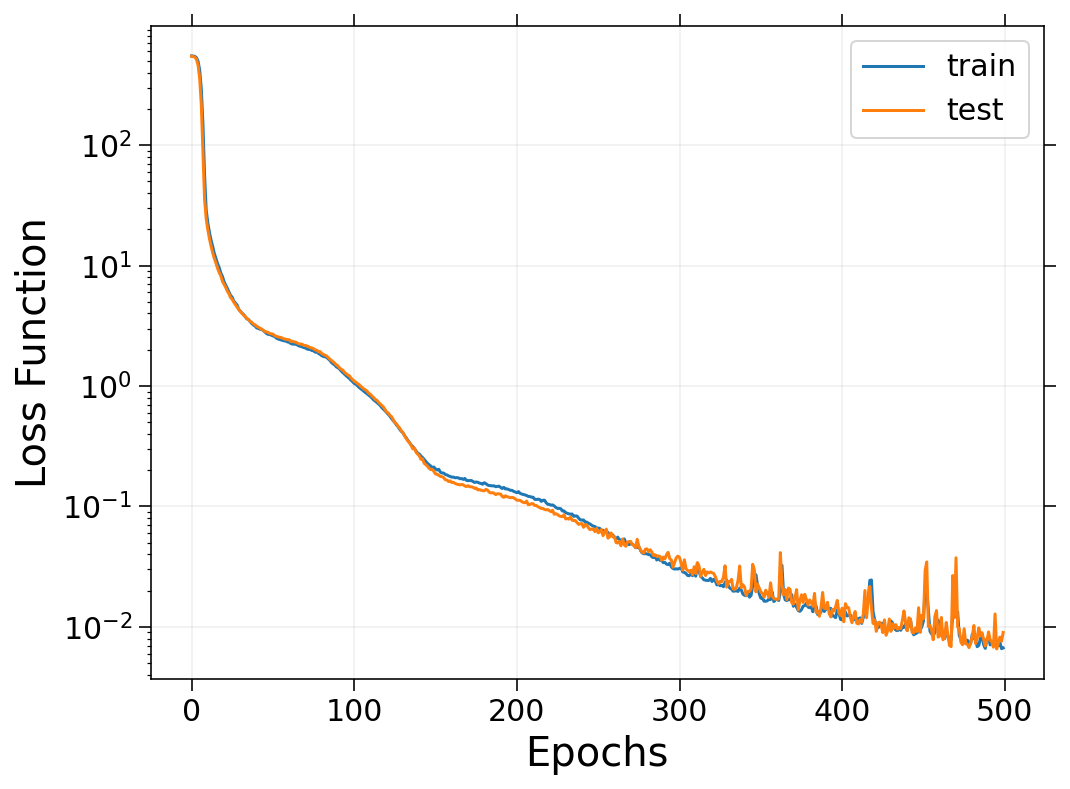

In [31]:
#Linear case:
plt.figure(figsize = (8,6))
plt.plot(hist_.history["loss"], label="train")
plt.plot(hist_.history["val_loss"], label="test")
plt.legend(fontsize=15)
plt.yscale("log")
plt.xlabel('Epochs')
plt.ylabel('Loss Function')
plt.rc('axes', labelsize=16)
plt.rc('axes', labelsize=20, titlesize=20)
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15
plt.grid(alpha=0.2)
plt.grid(alpha=0.2)
plt.tick_params(top=True,right=True, length=6)
plt.savefig('Loss_Func_H0.jpg')
plt.tight_layout

In [32]:
%%time
#Building the NN for NONLINEAR:

# reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.01,
#                                   patience=30, min_lr=0.000000001)
# e_s = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=100)

tf_model_nonlin = Sequential()
# Defining the input layer of the model
tf_model_nonlin.add(Dense(units=250, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu')) # 
 
# Defining 1st Hidden layer of the model
tf_model_nonlin.add(Dense(units=250, kernel_initializer='normal', activation='relu'))

# Defining 2nd Hidden layer of the model
tf_model_nonlin.add(Dense(units=250, kernel_initializer='normal', activation='relu'))

# Defining the 3rd hidden layer of the model
#tf_model_nonlin.add(Dense(units=150, kernel_initializer='normal', activation='relu'))  

# Defining the 4th hidden layer of the model
#tf_model_nonlin.add(Dense(units=150, kernel_initializer='normal', activation='relu')) 

#Defining the output layer of the model
tf_model_nonlin.add(Dense(500, kernel_initializer='normal'))
 
# opt = keras.optimizers.Adam(learning_rate=1e-4)
#opt = keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)  
    
# Compiling the model
tf_model_nonlin.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])
 
# Fitting the ANN to the Training set
hist_nonlin = tf_model_nonlin.fit(X_train_nonlin, y_train_nonlin, batch_size = 2, epochs = 500, validation_split=0.2, verbose=1) # callbacks=[reduce_lr, e_s],
            
# Mean absolute percentage error
MAPE = np.mean(np.abs((y_test_nonlin - tf_model_nonlin.predict(X_test_nonlin))/y_test_nonlin))*100
print(np.shape(100-MAPE))
print('Accuracy:', 100-MAPE)
#99.44523163935358, l_rate = 1e-4, 250 epochs, batch size = 50, 0.9837
#99.59918915882399, l_rate = 1e-4, 250 epochs, batch size = 20, 0.9934
tf_model_nonlin.summary()

Epoch 1/500
32/32 [==============================] - 1s 7ms/step - loss: 1.0277 - accuracy: 0.0000e+00 - val_loss: 1.0415 - val_accuracy: 0.0000e+00
Epoch 2/500
32/32 [==============================] - 0s 5ms/step - loss: 1.0078 - accuracy: 0.0625 - val_loss: 1.0034 - val_accuracy: 0.0000e+00
Epoch 3/500
32/32 [==============================] - 0s 5ms/step - loss: 0.9460 - accuracy: 0.0781 - val_loss: 0.9029 - val_accuracy: 0.0000e+00
Epoch 4/500
32/32 [==============================] - 0s 4ms/step - loss: 0.7809 - accuracy: 0.0781 - val_loss: 0.6651 - val_accuracy: 0.0000e+00
Epoch 5/500
32/32 [==============================] - 0s 4ms/step - loss: 0.4814 - accuracy: 0.0781 - val_loss: 0.3242 - val_accuracy: 0.0000e+00
Epoch 6/500
32/32 [==============================] - 0s 4ms/step - loss: 0.1880 - accuracy: 0.0781 - val_loss: 0.1076 - val_accuracy: 0.0000e+00
Epoch 7/500
32/32 [==============================] - 0s 4ms/step - loss: 0.0797 - accuracy: 0.0781 - val_loss: 0.0546 - val_ac

32/32 [==============================] - 0s 4ms/step - loss: 0.0119 - accuracy: 0.1406 - val_loss: 0.0123 - val_accuracy: 0.0625
Epoch 58/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0113 - accuracy: 0.1562 - val_loss: 0.0121 - val_accuracy: 0.0625
Epoch 59/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0108 - accuracy: 0.1719 - val_loss: 0.0114 - val_accuracy: 0.0625
Epoch 60/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0102 - accuracy: 0.1719 - val_loss: 0.0112 - val_accuracy: 0.0625
Epoch 61/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0097 - accuracy: 0.1562 - val_loss: 0.0109 - val_accuracy: 0.0625
Epoch 62/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0092 - accuracy: 0.2344 - val_loss: 0.0105 - val_accuracy: 0.0625
Epoch 63/500
32/32 [==============================] - 0s 4ms/step - loss: 0.0088 - accuracy: 0.2500 - val_loss: 0.0103 - val_accuracy: 0.0625
Epoch 64/500
32/32 

Epoch 115/500
32/32 [==============================] - 0s 4ms/step - loss: 0.0040 - accuracy: 0.5781 - val_loss: 0.0048 - val_accuracy: 0.2500
Epoch 116/500
32/32 [==============================] - 0s 4ms/step - loss: 0.0039 - accuracy: 0.6406 - val_loss: 0.0050 - val_accuracy: 0.2500
Epoch 117/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0038 - accuracy: 0.5781 - val_loss: 0.0046 - val_accuracy: 0.2500
Epoch 118/500
32/32 [==============================] - 0s 4ms/step - loss: 0.0038 - accuracy: 0.6406 - val_loss: 0.0046 - val_accuracy: 0.2500
Epoch 119/500
32/32 [==============================] - 0s 4ms/step - loss: 0.0037 - accuracy: 0.6094 - val_loss: 0.0042 - val_accuracy: 0.2500
Epoch 120/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0037 - accuracy: 0.6875 - val_loss: 0.0043 - val_accuracy: 0.2500
Epoch 121/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0037 - accuracy: 0.6406 - val_loss: 0.0043 - val_accuracy: 0.2500

32/32 [==============================] - 0s 6ms/step - loss: 9.6998e-04 - accuracy: 0.7500 - val_loss: 0.0010 - val_accuracy: 0.5000
Epoch 173/500
32/32 [==============================] - 0s 4ms/step - loss: 9.8627e-04 - accuracy: 0.7188 - val_loss: 0.0013 - val_accuracy: 0.5000
Epoch 174/500
32/32 [==============================] - 0s 4ms/step - loss: 0.0010 - accuracy: 0.7188 - val_loss: 8.3239e-04 - val_accuracy: 0.5625
Epoch 175/500
32/32 [==============================] - 0s 4ms/step - loss: 0.0012 - accuracy: 0.7188 - val_loss: 0.0012 - val_accuracy: 0.5625
Epoch 176/500
32/32 [==============================] - 0s 4ms/step - loss: 0.0013 - accuracy: 0.7344 - val_loss: 0.0010 - val_accuracy: 0.5000
Epoch 177/500
32/32 [==============================] - 0s 4ms/step - loss: 0.0010 - accuracy: 0.7812 - val_loss: 7.1683e-04 - val_accuracy: 0.5000
Epoch 178/500
32/32 [==============================] - 0s 4ms/step - loss: 7.9787e-04 - accuracy: 0.7344 - val_loss: 7.9965e-04 - val_accura

Epoch 227/500
32/32 [==============================] - 0s 4ms/step - loss: 2.7477e-04 - accuracy: 0.7500 - val_loss: 2.9593e-04 - val_accuracy: 0.7500
Epoch 228/500
32/32 [==============================] - 0s 4ms/step - loss: 2.6016e-04 - accuracy: 0.7500 - val_loss: 2.3497e-04 - val_accuracy: 0.7500
Epoch 229/500
32/32 [==============================] - 0s 3ms/step - loss: 2.5552e-04 - accuracy: 0.7344 - val_loss: 2.8114e-04 - val_accuracy: 0.7500
Epoch 230/500
32/32 [==============================] - 0s 4ms/step - loss: 2.9400e-04 - accuracy: 0.7969 - val_loss: 3.1601e-04 - val_accuracy: 0.7500
Epoch 231/500
32/32 [==============================] - 0s 4ms/step - loss: 3.2542e-04 - accuracy: 0.7969 - val_loss: 2.6691e-04 - val_accuracy: 0.7500
Epoch 232/500
32/32 [==============================] - 0s 4ms/step - loss: 2.5054e-04 - accuracy: 0.7500 - val_loss: 1.9270e-04 - val_accuracy: 0.7500
Epoch 233/500
32/32 [==============================] - 0s 4ms/step - loss: 2.6112e-04 - accura

32/32 [==============================] - 0s 4ms/step - loss: 1.5294e-04 - accuracy: 0.7500 - val_loss: 1.5849e-04 - val_accuracy: 0.8750
Epoch 282/500
32/32 [==============================] - 0s 4ms/step - loss: 1.4094e-04 - accuracy: 0.7500 - val_loss: 1.5991e-04 - val_accuracy: 0.8750
Epoch 283/500
32/32 [==============================] - 0s 4ms/step - loss: 1.3316e-04 - accuracy: 0.7969 - val_loss: 1.3563e-04 - val_accuracy: 0.8750
Epoch 284/500
32/32 [==============================] - 0s 4ms/step - loss: 1.2920e-04 - accuracy: 0.7969 - val_loss: 1.6778e-04 - val_accuracy: 0.8750
Epoch 285/500
32/32 [==============================] - 0s 4ms/step - loss: 1.2991e-04 - accuracy: 0.7969 - val_loss: 1.5350e-04 - val_accuracy: 0.8750
Epoch 286/500
32/32 [==============================] - 0s 4ms/step - loss: 1.1790e-04 - accuracy: 0.8281 - val_loss: 1.1988e-04 - val_accuracy: 0.8750
Epoch 287/500
32/32 [==============================] - 0s 4ms/step - loss: 1.3248e-04 - accuracy: 0.7031 - v

32/32 [==============================] - 0s 4ms/step - loss: 1.1779e-04 - accuracy: 0.7500 - val_loss: 1.6868e-04 - val_accuracy: 0.8750
Epoch 336/500
32/32 [==============================] - 0s 4ms/step - loss: 1.4762e-04 - accuracy: 0.7969 - val_loss: 2.9767e-04 - val_accuracy: 0.8750
Epoch 337/500
32/32 [==============================] - 0s 4ms/step - loss: 1.3606e-04 - accuracy: 0.8125 - val_loss: 1.0570e-04 - val_accuracy: 0.8750
Epoch 338/500
32/32 [==============================] - 0s 3ms/step - loss: 1.1600e-04 - accuracy: 0.7656 - val_loss: 1.2917e-04 - val_accuracy: 0.9375
Epoch 339/500
32/32 [==============================] - 0s 3ms/step - loss: 1.0509e-04 - accuracy: 0.8438 - val_loss: 1.4230e-04 - val_accuracy: 0.8750
Epoch 340/500
32/32 [==============================] - 0s 4ms/step - loss: 1.1081e-04 - accuracy: 0.7812 - val_loss: 1.1119e-04 - val_accuracy: 0.8750
Epoch 341/500
32/32 [==============================] - 0s 4ms/step - loss: 1.0220e-04 - accuracy: 0.8438 - v

32/32 [==============================] - 0s 3ms/step - loss: 1.2709e-04 - accuracy: 0.8438 - val_loss: 1.3168e-04 - val_accuracy: 0.8750
Epoch 390/500
32/32 [==============================] - 0s 4ms/step - loss: 2.5122e-04 - accuracy: 0.7812 - val_loss: 2.7021e-04 - val_accuracy: 0.8750
Epoch 391/500
32/32 [==============================] - 0s 4ms/step - loss: 5.2617e-04 - accuracy: 0.8125 - val_loss: 2.1665e-04 - val_accuracy: 0.9375
Epoch 392/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0010 - accuracy: 0.8125 - val_loss: 3.5313e-04 - val_accuracy: 0.9375
Epoch 393/500
32/32 [==============================] - 0s 4ms/step - loss: 0.0019 - accuracy: 0.7969 - val_loss: 0.0017 - val_accuracy: 0.9375
Epoch 394/500
32/32 [==============================] - 0s 4ms/step - loss: 6.7549e-04 - accuracy: 0.7656 - val_loss: 2.0747e-04 - val_accuracy: 0.8750
Epoch 395/500
32/32 [==============================] - 0s 4ms/step - loss: 4.2491e-04 - accuracy: 0.8125 - val_loss: 4.4

32/32 [==============================] - 0s 3ms/step - loss: 6.8666e-05 - accuracy: 0.8125 - val_loss: 7.7925e-05 - val_accuracy: 0.8750
Epoch 444/500
32/32 [==============================] - 0s 3ms/step - loss: 1.0222e-04 - accuracy: 0.8125 - val_loss: 1.2193e-04 - val_accuracy: 0.9375
Epoch 445/500
32/32 [==============================] - 0s 3ms/step - loss: 8.3055e-05 - accuracy: 0.8281 - val_loss: 6.1786e-05 - val_accuracy: 0.8750
Epoch 446/500
32/32 [==============================] - 0s 4ms/step - loss: 7.1129e-05 - accuracy: 0.7812 - val_loss: 9.0394e-05 - val_accuracy: 0.9375
Epoch 447/500
32/32 [==============================] - 0s 4ms/step - loss: 7.1035e-05 - accuracy: 0.8125 - val_loss: 8.2071e-05 - val_accuracy: 0.8750
Epoch 448/500
32/32 [==============================] - 0s 4ms/step - loss: 6.7685e-05 - accuracy: 0.8281 - val_loss: 7.7729e-05 - val_accuracy: 0.9375
Epoch 449/500
32/32 [==============================] - 0s 4ms/step - loss: 7.4556e-05 - accuracy: 0.7969 - v

32/32 [==============================] - 0s 3ms/step - loss: 3.4327e-04 - accuracy: 0.7812 - val_loss: 1.4866e-04 - val_accuracy: 0.9375
Epoch 498/500
32/32 [==============================] - 0s 3ms/step - loss: 1.4989e-04 - accuracy: 0.8281 - val_loss: 1.0513e-04 - val_accuracy: 0.9375
Epoch 499/500
32/32 [==============================] - 0s 4ms/step - loss: 6.7616e-05 - accuracy: 0.8281 - val_loss: 9.0650e-05 - val_accuracy: 0.9375
Epoch 500/500
32/32 [==============================] - 0s 3ms/step - loss: 6.1100e-05 - accuracy: 0.8438 - val_loss: 5.7519e-05 - val_accuracy: 0.9375
()
Accuracy: -18471.928846484218
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 250)               500       
                                                                 
 dense_21 (Dense)            (None, 250)               62750     
                         

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

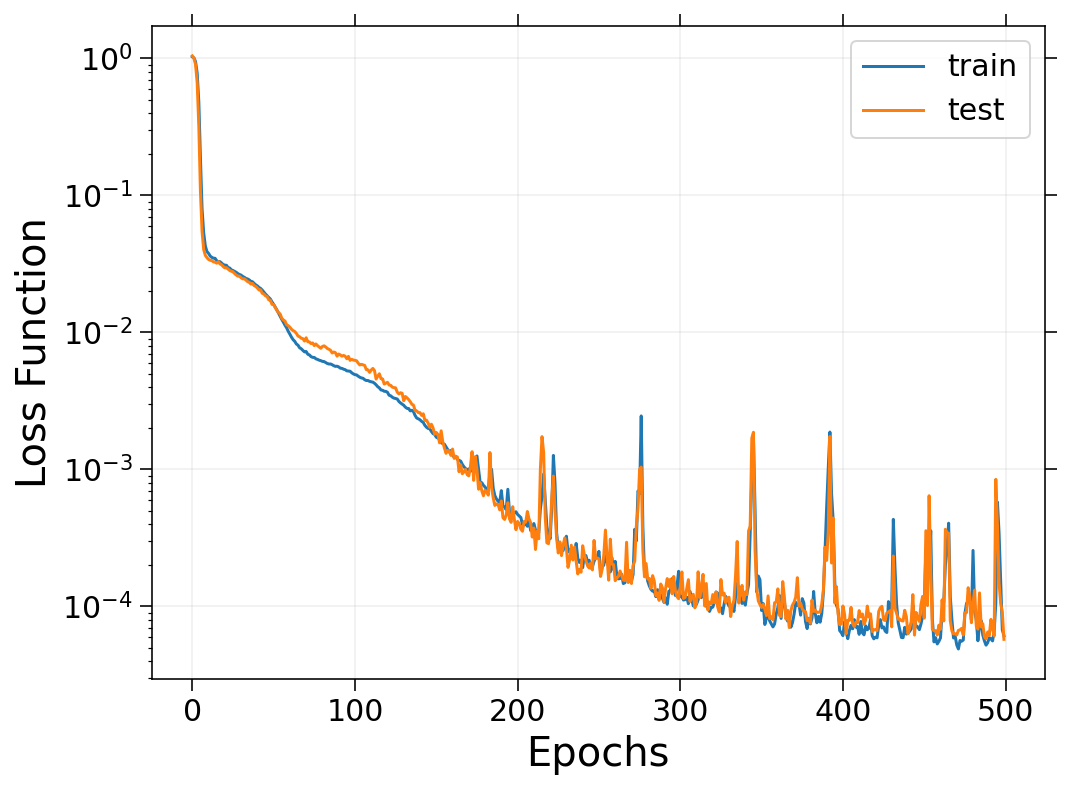

In [33]:
plt.figure(figsize = (8,6))
plt.plot(hist_nonlin.history["loss"], label="train")
plt.plot(hist_nonlin.history["val_loss"], label="test")
plt.legend(fontsize=15)
plt.yscale("log")
plt.xlabel('Epochs')
plt.ylabel('Loss Function')
plt.rc('axes', labelsize=16)
plt.rc('axes', labelsize=20, titlesize=20)
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15
plt.grid(alpha=0.2)
plt.grid(alpha=0.2)
plt.tick_params(top=True,right=True, length=6)
plt.savefig('Loss_Func_H0.jpg')
plt.tight_layout

H0: 64.0 - 80.0 67


parameter:  ['67']
user_list: [67.0]
cosmo_arr [[67.]]
cosmo_arr[0] [67.]
input_scaled [[-1.07176003]]
H0: 67.0


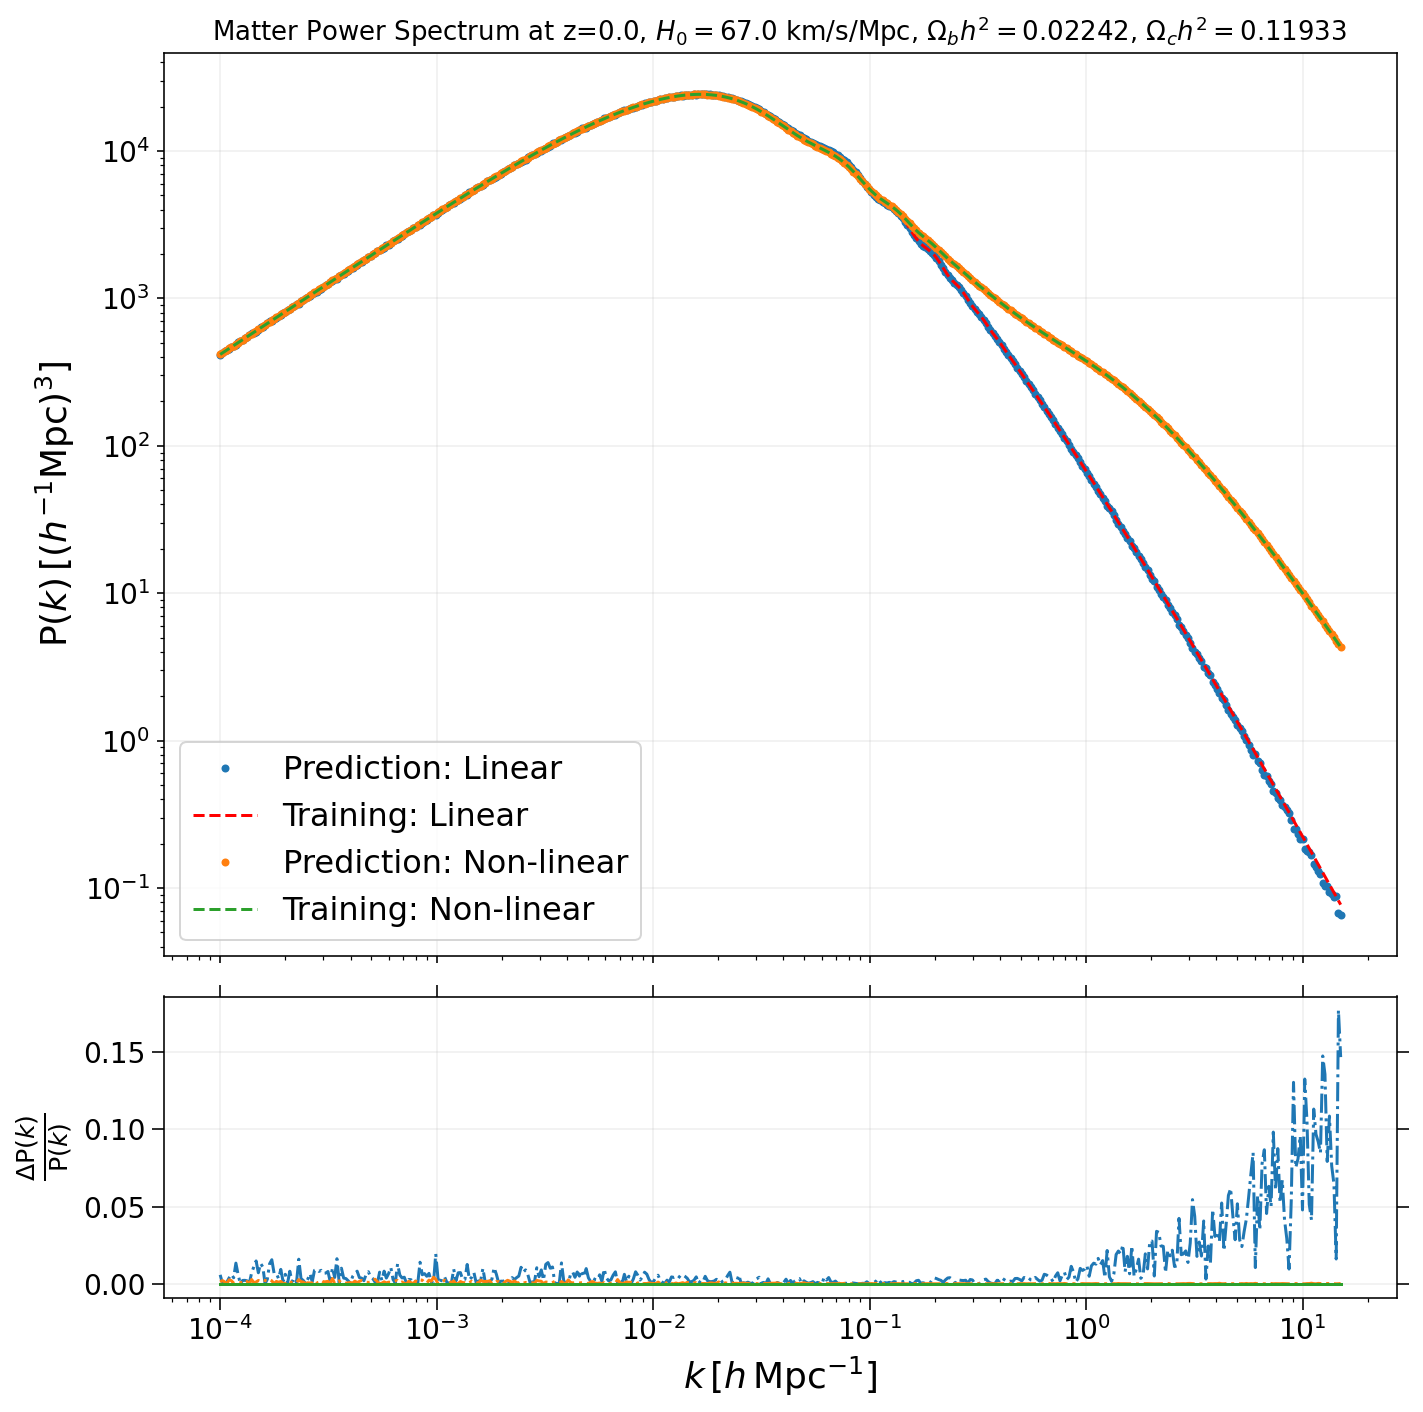

In [37]:
#Define func:

def calc_cosmo():
    input_cosmo_val = input('H0: 64.0 - 80.0 ')
    print("\n")
    user_list = input_cosmo_val.split()
    # print list
    print('parameter: ', user_list)

    # convert each item to float type
    for i in range(len(user_list)):
        # convert each item to float type
        user_list[i] = float(user_list[i])
    print("user_list:", user_list)
        
    
    cosmo_arr = np.reshape(np.array(user_list),(1, X_train.shape[1]))
    #cosmo_arr_nonlin = np.reshape(np.array(user_list),(1, X_train_nonlin.shape[1]))
    print('cosmo_arr', cosmo_arr)
    print('cosmo_arr[0]', cosmo_arr[0])
    scaled = train_input_data.fit(input_data.values)
    input_scaled = scaled.transform(cosmo_arr)
    #input_scaled_nonlin = scaled.transform(cosmo_arr_nonlin)
    print('input_scaled', input_scaled)
    
    pred_pk = scaled_output.inverse_transform(tf_model.predict([input_scaled]))
    pred_pk_nonlin = scaled_output.inverse_transform(tf_model_nonlin.predict([input_scaled]))
    #Return to log scale for pred:
    #pred_pk = np.exp(pred_rescaled_pk)
    
    
    #Compute P.S via CAMB:
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=cosmo_arr[0][0], ombh2=0.02242, omch2=0.11933)
    pars.InitPower.set_params(As = 2.105209331e-9, ns=0.9665)
    pars.set_matter_power(redshifts=[0.0], kmax=15.0)
    pars.set_dark_energy(w=-1.0, wa=0, dark_energy_model='fluid')

    # Linear spectra
    pars.NonLinear = model.NonLinear_none
    results = camb.get_results(pars)
    camb_kh, z, camb_pk_cur = results.get_matter_power_spectrum(minkh=1e-4, maxkh=15, npoints=500)
    s8_current = np.array(results.get_sigma8())
    s8_fid = np.array([0.8102])
    renorm_s8 = (s8_fid/s8_current)**2
    camb_pk = renorm_s8*camb_pk_cur

    # Non-Linear spectra (Halofit)
    pars.NonLinear = model.NonLinear_both
    results.calc_power_spectra(pars)
    camb_kh_nonlin, z_nonlin, camb_pk_nonlin_cur = results.get_matter_power_spectrum(minkh=1e-4, maxkh=15, npoints = 500)
    camb_pk_nonlin = renorm_s8*camb_pk_nonlin_cur

    print('H0:' , cosmo_arr[0][0])
    #print(pred_pk)
    
    fig, ax = plt.subplots(2,1, sharex=True, figsize = (10,10), gridspec_kw={'height_ratios': [3, 1]})                                            
    ax[0].loglog(camb_kh, pred_pk[0], "C0.")                                                          # prediction                            
    ax[0].loglog(camb_kh, camb_pk[0], 'r', linestyle='dashed')                                          # CAMB
    ax[0].loglog(camb_kh, pred_pk_nonlin[0], "C1.")
    ax[0].loglog(camb_kh, camb_pk_nonlin[0], 'C2', linestyle='dashed') 
    ax[0].set_title('Matter Power Spectrum at z=0.0, $H_{0} = %0.5s \ \mathregular{km/s/Mpc}$, ' %cosmo_arr[0][0] + '$\Omega_{b}h^{2} = 0.02242$, ' + '$\Omega_{c}h^{2} = 0.11933$ ', fontsize = 13)
    plt.rc('axes', labelsize=18)
    plt.rc('axes', titlesize=16)
    plt.rcParams['xtick.labelsize']=14
    plt.rcParams['ytick.labelsize']=14
    plt.xlabel(r'$k\,[h\,\mathrm{Mpc}^{-1}]$')
    ax[0].set_ylabel(r'$\mathrm{P}(k)\, [(h^{-1}\mathrm{Mpc})^{3}]$')
    ax[0].legend(['Prediction: Linear', 'Training: Linear', 'Prediction: Non-linear', 'Training: Non-linear'], loc='lower left', fontsize=16);
    ax[0].grid(alpha=0.2)
    ax[1].grid(alpha=0.2)
    plt.tick_params(top=True,right=True, length=6)
    
    #residual plot 
    ax[1].set_ylabel(r'$\frac{\Delta \mathrm{P}(k)}{\mathrm{P}(k)}$')
    ax[1].plot(camb_kh, np.abs((pred_pk[0]-camb_pk[0])/camb_pk[0]), 'C0', linestyle="dashdot") 
    ax[1].plot(camb_kh, np.abs((camb_pk[0]-camb_pk[0])/camb_pk[0]), 'r')
    ax[1].plot(camb_kh, np.abs((pred_pk_nonlin[0]-camb_pk_nonlin[0])/camb_pk_nonlin[0]), 'C1', linestyle="dashdot") 
    ax[1].plot(camb_kh, np.abs((camb_pk_nonlin[0]-camb_pk_nonlin[0])/camb_pk_nonlin[0]), 'C2')
    ax[1].set_yscale('linear')
    #ax[1].set_ylim(0, 0.05)
    fig.tight_layout()
    #plt.savefig('NN_MPS_H0.jpg')
    plt.show()
    

Generate = calc_cosmo()



parameter:  64.0
user_list: 64.0
cosmo_arr [[64.]]
cosmo_arr[0] [64.]
input_scaled [[-1.71481604]]
H0: 64.0


parameter:  66.28571428571429
user_list: 66.28571428571429
cosmo_arr [[66.28571429]]
cosmo_arr[0] [66.28571429]
input_scaled [[-1.2248686]]
H0: 66.28571428571429


parameter:  68.57142857142857
user_list: 68.57142857142857
cosmo_arr [[68.57142857]]
cosmo_arr[0] [68.57142857]
input_scaled [[-0.73492116]]
H0: 68.57142857142857


parameter:  70.85714285714286
user_list: 70.85714285714286
cosmo_arr [[70.85714286]]
cosmo_arr[0] [70.85714286]
input_scaled [[-0.24497372]]
H0: 70.85714285714286


parameter:  73.14285714285714
user_list: 73.14285714285714
cosmo_arr [[73.14285714]]
cosmo_arr[0] [73.14285714]
input_scaled [[0.24497372]]
H0: 73.14285714285714


parameter:  75.42857142857143
user_list: 75.42857142857143
cosmo_arr [[75.42857143]]
cosmo_arr[0] [75.42857143]
input_scaled [[0.73492116]]
H0: 75.42857142857143


parameter:  77.71428571428571
user_list: 77.71428571428571
cosmo_a

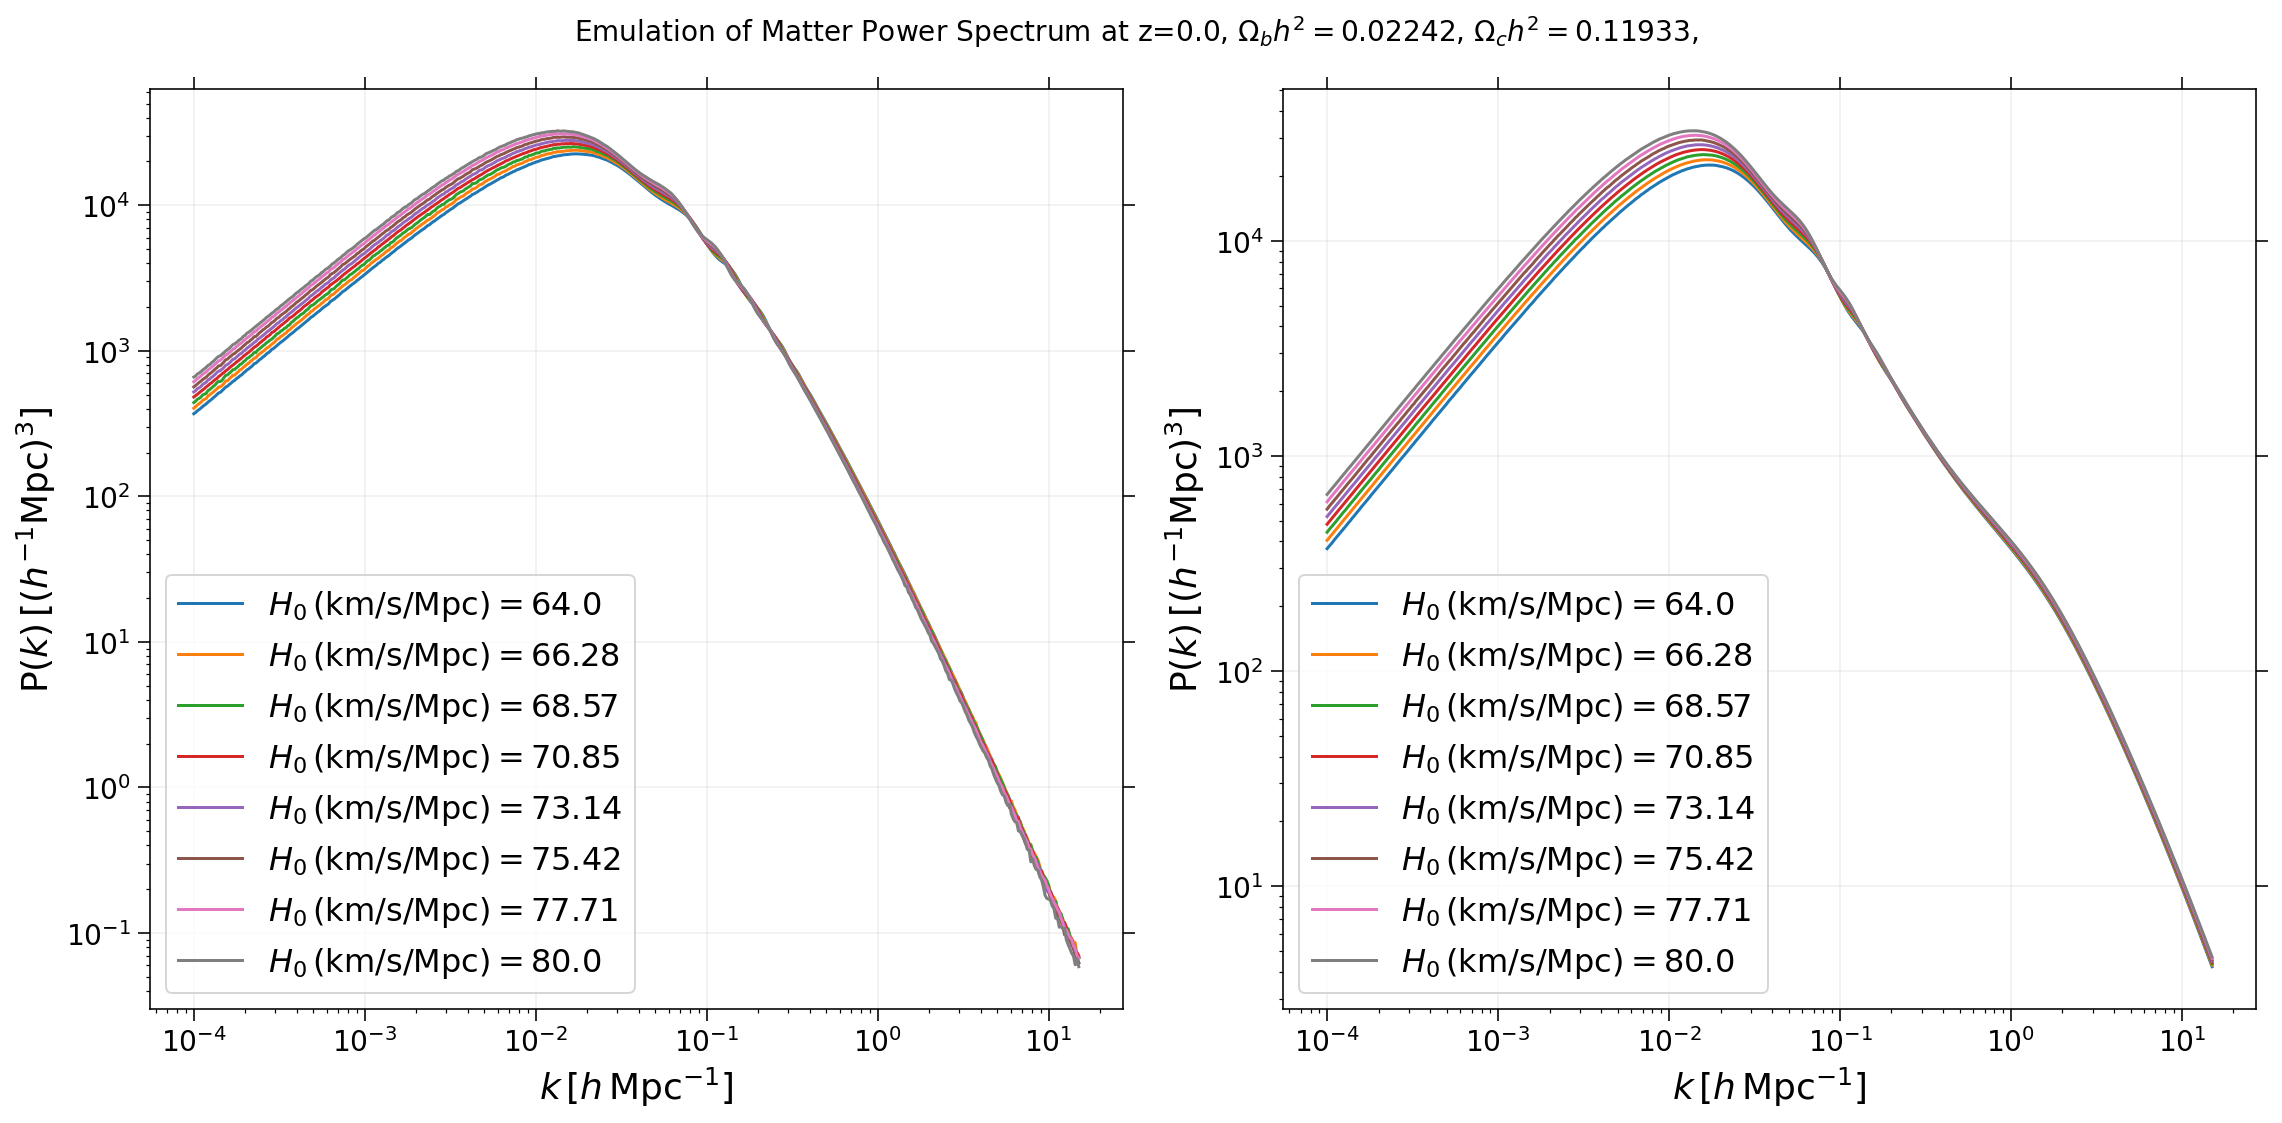

In [56]:
#Define func:

def calc_cosmo():
    fig, ax = plt.subplots(1,2, sharex=True, figsize = (16,8)) #, gridspec_kw={'height_ratios': [3, 1]}
    H0_input = np.linspace(64.0, 80.0, 8)
    for w in H0_input:
        
        print("\n")
        user_list = float(w)
        # print list
        print('parameter: ', user_list)

        # convert each item to float type
        print("user_list:", user_list)
        
    
        cosmo_arr = np.reshape(np.array(user_list),(1, X_train.shape[1]))
        print('cosmo_arr', cosmo_arr)
        print('cosmo_arr[0]', cosmo_arr[0])
        scaled = train_input_data.fit(input_data.values)
        input_scaled = scaled.transform(cosmo_arr)
        print('input_scaled', input_scaled)

        pred_pk = scaled_output.inverse_transform(tf_model.predict([input_scaled]))
        pred_pk_nonlin = scaled_output.inverse_transform(tf_model_nonlin.predict([input_scaled]))
        #Return to log scale for pred:
        #pred_pk = np.exp(pred_rescaled_pk)
    
    
        #Compute P.S via CAMB:
        pars = camb.CAMBparams()
        pars.set_cosmology(H0=cosmo_arr[0][0], ombh2=0.02242, omch2=0.11933)
        pars.InitPower.set_params(As = 2.105209331e-9, ns=0.9665)
        pars.set_matter_power(redshifts=[0.0], kmax=15.0)
        pars.set_dark_energy(w=-1.0, wa=0, dark_energy_model='fluid')

        # Linear spectra
        pars.NonLinear = model.NonLinear_none
        results = camb.get_results(pars)
        camb_kh, z, camb_pk_cur = results.get_matter_power_spectrum(minkh=1e-4, maxkh=15, npoints=500)
        s8_current = np.array(results.get_sigma8())
        s8_fid = np.array([0.8102])
        renorm_s8 = (s8_fid/s8_current)**2
        camb_pk = renorm_s8*camb_pk_cur

        # Non-Linear spectra (Halofit)
        pars.NonLinear = model.NonLinear_both
        results.calc_power_spectra(pars)
        camb_kh_nonlin, z_nonlin, camb_pk_nonlin_cur = results.get_matter_power_spectrum(minkh=1e-4, maxkh=15, npoints = 500)
        camb_pk_nonlin = renorm_s8*camb_pk_nonlin_cur

        print('H0:' , cosmo_arr[0][0])
                                            
        ax[0].loglog(camb_kh, pred_pk[0])                                                                                   
        ax[1].loglog(camb_kh, pred_pk_nonlin[0])                                                  
    fig.suptitle('Emulation of Matter Power Spectrum at z=0.0, ' + '$\Omega_{b}h^{2} = 0.02242$, ' + '$\Omega_{c}h^{2} = 0.11933$, ', fontsize = 14)
    plt.rc('axes', labelsize=18)
    plt.rc('axes', titlesize=16)
    plt.rcParams['xtick.labelsize']=14
    plt.rcParams['ytick.labelsize']=14
    ax[0].set_xlabel(r'$k\,[h\,\mathrm{Mpc}^{-1}]$')
    ax[0].set_ylabel(r'$\mathrm{P}(k)\, [(h^{-1}\mathrm{Mpc})^{3}]$')
    ax[0].legend(["$H_{0}\,\mathregular{(km/s/Mpc)} = %0.5s$"%w for w in  H0_input], loc='lower left', fontsize=16);
    ax[0].grid(alpha=0.2)
    ax[1].grid(alpha=0.2)
    ax[0].tick_params(top=True,right=True, length=6)
    
    plt.rc('axes', labelsize=18)
    plt.rc('axes', titlesize=16)
    plt.rcParams['xtick.labelsize']=14
    plt.rcParams['ytick.labelsize']=14
    ax[1].set_xlabel(r'$k\,[h\,\mathrm{Mpc}^{-1}]$')
    ax[1].set_ylabel(r'$\mathrm{P}(k)\, [(h^{-1}\mathrm{Mpc})^{3}]$')
    ax[1].legend(["$H_{0}\,\mathregular{(km/s/Mpc)} = %0.5s$"%w for w in  H0_input], loc='lower left', fontsize=16);
    ax[1].tick_params(top=True,right=True, length=6)

    fig.tight_layout()
    #plt.savefig('NN_MPS_H0_range.jpg')
    plt.show()
    

Generate = calc_cosmo()



parameter:  64.0
user_list: 64.0
cosmo_arr [[64.]]
cosmo_arr[0] [64.]
input_scaled [[-1.71481604]]
H0: 64.0


parameter:  66.28571428571429
user_list: 66.28571428571429
cosmo_arr [[66.28571429]]
cosmo_arr[0] [66.28571429]
input_scaled [[-1.2248686]]
H0: 66.28571428571429


parameter:  68.57142857142857
user_list: 68.57142857142857
cosmo_arr [[68.57142857]]
cosmo_arr[0] [68.57142857]
input_scaled [[-0.73492116]]
H0: 68.57142857142857


parameter:  70.85714285714286
user_list: 70.85714285714286
cosmo_arr [[70.85714286]]
cosmo_arr[0] [70.85714286]
input_scaled [[-0.24497372]]
H0: 70.85714285714286


parameter:  73.14285714285714
user_list: 73.14285714285714
cosmo_arr [[73.14285714]]
cosmo_arr[0] [73.14285714]
input_scaled [[0.24497372]]
H0: 73.14285714285714


parameter:  75.42857142857143
user_list: 75.42857142857143
cosmo_arr [[75.42857143]]
cosmo_arr[0] [75.42857143]
input_scaled [[0.73492116]]
H0: 75.42857142857143


parameter:  77.71428571428571
user_list: 77.71428571428571
cosmo_a

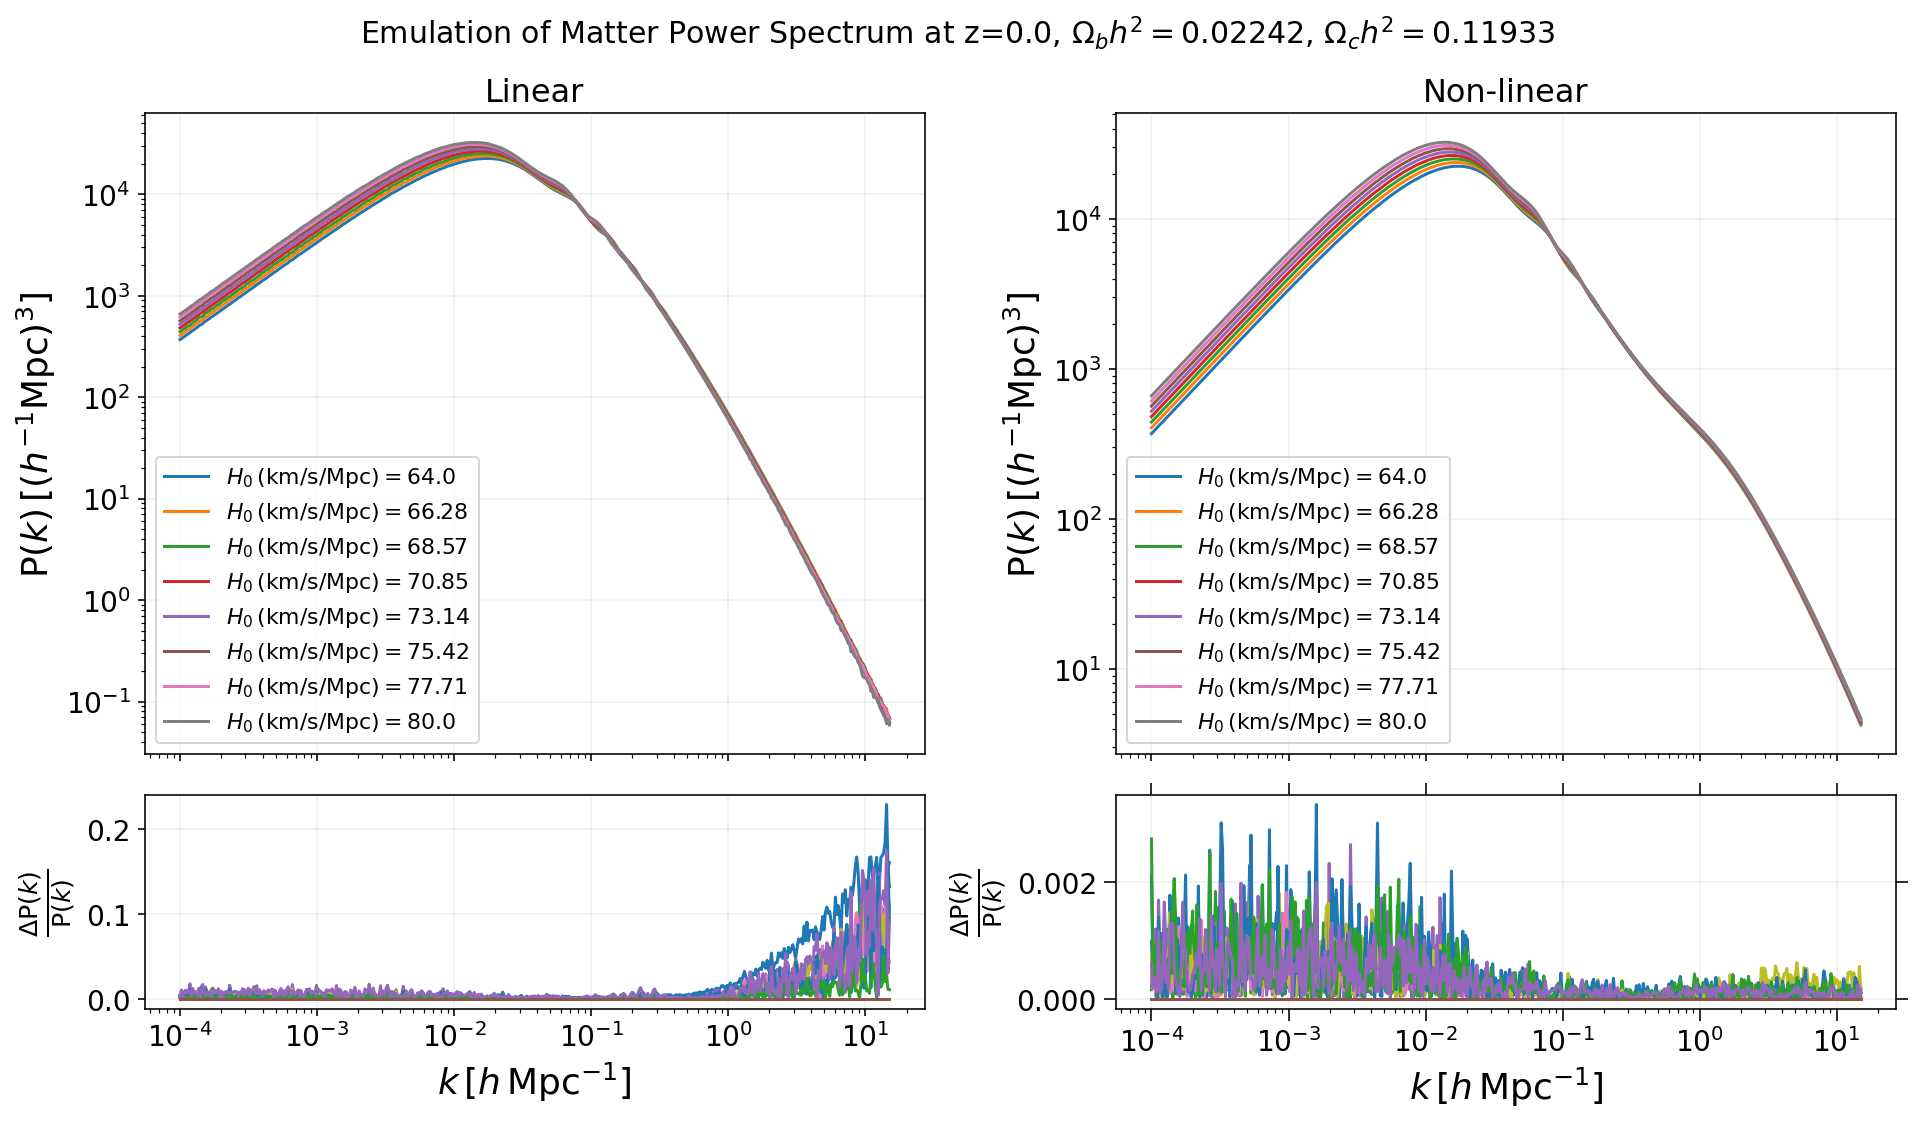

In [72]:
# Define func:

def calc_cosmo():
    
    fig, ax = plt.subplots(2,2, sharex=True, figsize = (13.5,8), gridspec_kw={'height_ratios': [3, 1]})
    H0_input = np.linspace(64.0, 80.0, 8)
    for w in H0_input:
        
        print("\n")
        user_list = float(w)
        # print list
        print('parameter: ', user_list)

        # convert each item to float type
        print("user_list:", user_list)
        
    
        cosmo_arr = np.reshape(np.array(user_list),(1, X_train.shape[1]))
        print('cosmo_arr', cosmo_arr)
        print('cosmo_arr[0]', cosmo_arr[0])
        scaled = train_input_data.fit(input_data.values)
        input_scaled = scaled.transform(cosmo_arr)
        print('input_scaled', input_scaled)

        pred_pk = scaled_output.inverse_transform(tf_model.predict([input_scaled]))
        pred_pk_nonlin = scaled_output.inverse_transform(tf_model_nonlin.predict([input_scaled]))
        #Return to log scale for pred:
        #pred_pk = np.exp(pred_rescaled_pk)
    
    
        #Compute P.S via CAMB:
        pars = camb.CAMBparams()
        pars.set_cosmology(H0=cosmo_arr[0][0], ombh2=0.02242, omch2=0.11933)
        pars.InitPower.set_params(As = 2.105209331e-9, ns=0.9665)
        pars.set_matter_power(redshifts=[0.0], kmax=15.0)
        pars.set_dark_energy(w=-1.0, wa=0, dark_energy_model='fluid')

        # Linear spectra
        pars.NonLinear = model.NonLinear_none
        results = camb.get_results(pars)
        camb_kh, z, camb_pk_cur = results.get_matter_power_spectrum(minkh=1e-4, maxkh=15, npoints=500)
        s8_current = np.array(results.get_sigma8())
        s8_fid = np.array([0.8102])
        renorm_s8 = (s8_fid/s8_current)**2
        camb_pk = renorm_s8*camb_pk_cur
        
        
        # Non-Linear spectra (Halofit)
        pars.NonLinear = model.NonLinear_both
        results.calc_power_spectra(pars)
        camb_kh_nonlin, z_nonlin, camb_pk_nonlin_cur = results.get_matter_power_spectrum(minkh=1e-4, maxkh=15, npoints = 500)
        camb_pk_nonlin = renorm_s8*camb_pk_nonlin_cur


        print('H0:' , cosmo_arr[0][0])
        
                                             
        ax[0,0].loglog(camb_kh, pred_pk[0])                                                                       
        ax[0,1].loglog(camb_kh, pred_pk_nonlin[0])
        
        #residual plot 
        ax[1,0].set_ylabel(r'$\frac{\Delta \mathrm{P}(k)}{\mathrm{P}(k)}$')
        ax[1,0].plot(camb_kh, np.abs((pred_pk[0]-camb_pk[0])/camb_pk[0])) 
        ax[1,0].plot(camb_kh, np.abs((camb_pk[0]-camb_pk[0])/camb_pk[0]))
        ax[1,0].set_yscale('linear')
        
        ax[1,1].set_ylabel(r'$\frac{\Delta \mathrm{P}(k)}{\mathrm{P}(k)}$')
        ax[1,1].plot(camb_kh, np.abs((pred_pk_nonlin[0]-camb_pk_nonlin[0])/camb_pk_nonlin[0])) 
        ax[1,1].plot(camb_kh, np.abs((camb_pk_nonlin[0]-camb_pk_nonlin[0])/camb_pk_nonlin[0]))
        ax[1,1].set_yscale('linear')
        #ax[1].set_ylim(0, 0.05)
        
    fig.suptitle('Emulation of Matter Power Spectra at z=0.0, ' + '$\Omega_{b}h^{2} = 0.02242$, ' + '$\Omega_{c}h^{2} = 0.11933$', fontsize = 15)
    ax[0,0].set_title('Linear')
    ax[0,1].set_title('Non-linear')
    plt.rc('axes', labelsize=18)
    plt.rc('axes', titlesize=16)
    plt.rcParams['xtick.labelsize']=14
    plt.rcParams['ytick.labelsize']=14
    ax[1,0].set_xlabel(r'$k\,[h\,\mathrm{Mpc}^{-1}]$')
    ax[1,1].set_xlabel(r'$k\,[h\,\mathrm{Mpc}^{-1}]$')
    ax[0,0].set_ylabel(r'$\mathrm{P}(k)\, [(h^{-1}\mathrm{Mpc})^{3}]$')
    ax[0,1].set_ylabel(r'$\mathrm{P}(k)\, [(h^{-1}\mathrm{Mpc})^{3}]$')
    ax[0,0].legend(["$H_{0}\,\mathregular{(km/s/Mpc)} = %0.5s$"%w for w in  H0_input], loc='lower left', fontsize=11);
    ax[0,1].legend(["$H_{0}\,\mathregular{(km/s/Mpc)} = %0.5s$"%w for w in  H0_input], loc='lower left', fontsize=11);
    ax[0,0].grid(alpha=0.2)
    ax[1,0].grid(alpha=0.2)
    ax[0,1].grid(alpha=0.2)
    ax[1,1].grid(alpha=0.2)
    plt.tick_params(top=True,right=True, length=6)


        
    fig.tight_layout()
    #plt.savefig('NN_MPS_H0_range.jpg')
    plt.show()
    

Generate = calc_cosmo()